In [3]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
from scipy.interpolate import make_interp_spline

In [4]:
def load_config():
    # Get the absolute path of the project root (one directory up)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

    # Normalize the project_root to ensure it's correctly formatted
    project_root = os.path.normpath(project_root)
    
    config_path = os.path.join(project_root, 'config.json')

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at expected location: {config_path}")

    with open(config_path, 'r') as f:
        config = json.load(f)

    return config, project_root

In [5]:
config, project_root = load_config()

group_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["enterprise"]))
group_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["mobile"]))
group_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["ics"]))

In [32]:
def analyze_techniques_multiple(csv_files: list[str]):
    """
    Analyze techniques across multiple CSV files and combine the data.
    
    Args:
        csv_files (list[str]): List of CSV file paths.
        
    Returns:
        tuple: combined results for unique techniques per group, most common techniques, and unique techniques per group only.
    """
    # Load and concatenate all dataframes from multiple sheets/files
    dfs = [pd.read_excel(f, sheet_name='techniques used') for f in csv_files]
    combined_df = pd.concat(dfs, ignore_index=True)

    # Extract relevant columns
    data = combined_df[['source ID', 'source name', 'target ID', 'target name', 'mapping description']]

    # Create mapping from target ID to name
    id_to_name_map = dict(zip(data['target ID'], data['target name']))

    # Unique Techniques per Source name (Group) including both target ID and target name
    unique_techniques_per_group = data.groupby('source name').apply(
        lambda x: [(tid, id_to_name_map[tid]) for tid in x['target ID'].unique()]
    ).to_dict()

    # Count Occurrences of Each Technique (target ID) across all groups
    technique_counts = data['target ID'].value_counts().reset_index()
    technique_counts.columns = ['target ID', 'count']

    # Join counts with target name
    most_common_techniques = technique_counts.merge(data[['target ID', 'target name']].drop_duplicates(), on='target ID')

    unique_technique_ids = set(data['target ID'].unique())
    total_unique_techniques = len(unique_technique_ids)


    # Techniques unique to a single group
    unique_techniques_per_group_only = {}

    techniques_used_once = technique_counts[technique_counts['count'] == 1]['target ID'].tolist()

    for group, techniques in unique_techniques_per_group.items():
        unique_to_group = [tech for tech in techniques if tech[0] in techniques_used_once]
        unique_techniques_per_group_only[group] = unique_to_group

    # New addition: number of techniques used by exactly 2 groups
    technique_group_counts = data.groupby('target ID')['source ID'].nunique()
    techniques_used_by_two_groups = technique_group_counts[technique_group_counts == 2]
    num_techniques_used_by_two_groups = len(techniques_used_by_two_groups)


    return unique_techniques_per_group, most_common_techniques, total_unique_techniques, unique_techniques_per_group_only, num_techniques_used_by_two_groups


In [33]:
# Then call it with all files:
all_files = [group_path_enterprise, group_path_mobile, group_path_ics]
unique_techniques, most_common, total_unique_techniques, unique_only, num_used_by_two = analyze_techniques_multiple(all_files)

C:\Users\ricewater\AppData\Local\Temp\ipykernel_13584\2011484789.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_techniques_per_group = data.groupby('source name').apply(


In [35]:
#total_unique_techniques
unique_once_ids = set()
for tech_list in unique_only.values():
    for tid, _ in tech_list:
        unique_once_ids.add(tid)

print(f"Total unique technique IDs present in the used by only one group list: {len(unique_once_ids)}")
#print(sorted(unique_once_ids))  # Uncomment to list them

Total unique technique IDs present in the used by only one group list: 147


In [36]:
non_empty_unique_count = sum(1 for techniques in unique_only.values() if techniques)
print(f"Number of groups with at least one unique technique: {non_empty_unique_count}")

Number of groups with at least one unique technique: 52


In [37]:
def summarize_parent_techniques(most_common_techniques_df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize techniques at the parent level and sort their sub-techniques by frequency.

    Args:
        most_common_techniques_df (pd.DataFrame): DataFrame with columns 'target ID', 'count', and 'target name'.

    Returns:
        pd.DataFrame: Summary with parent technique ID, total count, and sorted sub-techniques as string.
    """

    summary = defaultdict(lambda: {'total_count': 0, 'sub_techniques': []})

    for _, row in most_common_techniques_df.iterrows():
        target_id = row['target ID']
        count = row['count']
        name = row['target name']

        parent_id = target_id.split('.')[0]
        summary[parent_id]['total_count'] += count
        summary[parent_id]['sub_techniques'].append((target_id, name, count))

    records = []
    for parent_id, details in summary.items():
        sorted_subs = sorted(details['sub_techniques'], key=lambda x: x[2], reverse=True)
        sub_tech_str = '; '.join([f"{tid} ({name}): {count}" for tid, name, count in sorted_subs])
        records.append({
            'Parent Technique': parent_id,
            'Total Count': details['total_count'],
            'Sub-techniques': sub_tech_str
        })

    return pd.DataFrame(records).sort_values(by='Total Count', ascending=False).reset_index(drop=True)


In [38]:
summary_df = summarize_parent_techniques(most_common)
summary_df.head(10)

,Parent Technique,Total Count,Sub-techniques
0,T1059,224,T1059.001 (PowerShell): 69; T1059.003 (Windows...
1,T1027,128,T1027.013 (Encrypted/Encoded File): 34; T1027....
2,T1566,126,T1566.001 (Spearphishing Attachment): 72; T156...
3,T1204,121,T1204.002 (Malicious File): 79; T1204.001 (Mal...
4,T1036,96,T1036.005 (Match Legitimate Name or Location):...
5,T1588,89,T1588.002 (Tool): 66; T1588.001 (Malware): 12;...
6,T1003,84,T1003.001 (LSASS Memory): 34; T1003.003 (NTDS)...
7,T1105,76,T1105 (Ingress Tool Transfer): 76
8,T1021,71,T1021.001 (Remote Desktop Protocol): 26; T1021...
9,T1071,69,T1071.001 (Web Protocols): 47; T1071.004 (DNS)...


In [39]:
### Storing the df to a CSV file

#summary_df["Sub-techniques"] = summary_df["Sub-techniques"].str.replace("; ", ";\n")
#summary_df.to_csv("parent_technique_summary.csv", index=False)

In [40]:
def load_combined_data(paths):
    """
    Load and combine 'techniques used' sheets from multiple Excel files.

    Parameters
    ----------
    paths : list
        List of file paths to Excel sheets.

    Returns
    -------
    DataFrame
        Combined DataFrame containing techniques from all domains.
    """
    all_data = []
    for path in paths:
        df = pd.read_excel(path, sheet_name='techniques used')
        df = df[['source ID', 'source name', 'target ID', 'target name', 'mapping description']]
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


In [41]:
paths = [group_path_enterprise, group_path_mobile, group_path_ics]
combined_data = load_combined_data(paths)

In [42]:
def analyze_combined_techniques(data):
    """
    Compute technique count per group and generate smooth CDF data.
    The CDF of "number of techniques per group" tells you:
    "What proportion of groups use ≤ n techniques?"

    Parameters
    ----------
    data : DataFrame
        Combined technique mapping data from all domains.

    Returns
    -------
    dict
        Dictionary containing statistical values and CDF coordinates.
    """
    # Unique techniques per group (grouped by 'source name')
    unique_techniques_per_group = data.groupby('source name')['target ID'].unique().to_dict()
    techniques_per_group = [len(techs) for techs in unique_techniques_per_group.values()]
    series = pd.Series(techniques_per_group)

    # CDF data
    sorted_counts = np.sort(techniques_per_group)
    cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

    # Smooth CDF
    x_to_y = defaultdict(list)
    for x, y in zip(sorted_counts, cdf):
        x_to_y[x].append(y)
    x_unique = np.array(sorted(x_to_y.keys()))
    y_avg = np.array([np.mean(x_to_y[x]) for x in x_unique])
    x_smooth = np.linspace(x_unique.min(), x_unique.max(), 300)
    spline = make_interp_spline(x_unique, y_avg, k=2)
    cdf_smooth = spline(x_smooth)

    return {
        "techniques_per_group": techniques_per_group,
        "mean": series.mean(),
        "median": series.median(),
        "std": series.std(),
        "min": series.min(),
        "max": series.max(),
        "quartiles": series.quantile([0.25, 0.5, 0.75]),
        "mode": series.mode()[0] if not series.mode().empty else None,
        "x_smooth": x_smooth,
        "cdf_smooth": cdf_smooth
    }

In [43]:
combined_stats = analyze_combined_techniques(combined_data)

In [44]:
print("=== Combined Stats ===")
print(f"Mean: {combined_stats['mean']:.2f}")
print(f"Median: {combined_stats['median']:.2f}")
print(f"Std Dev: {combined_stats['std']:.2f}")
print(f"Min: {combined_stats['min']}")
print(f"Max: {combined_stats['max']}")
print(f"Mode: {combined_stats['mode']}")
print(f"Quartiles:\n{combined_stats['quartiles']}")


=== Combined Stats ===
Mean: 23.20
Median: 14.50
Std Dev: 21.51
Min: 1
Max: 92
Mode: 9
Quartiles:
0.25     7.00
0.50    14.50
0.75    35.25
dtype: float64


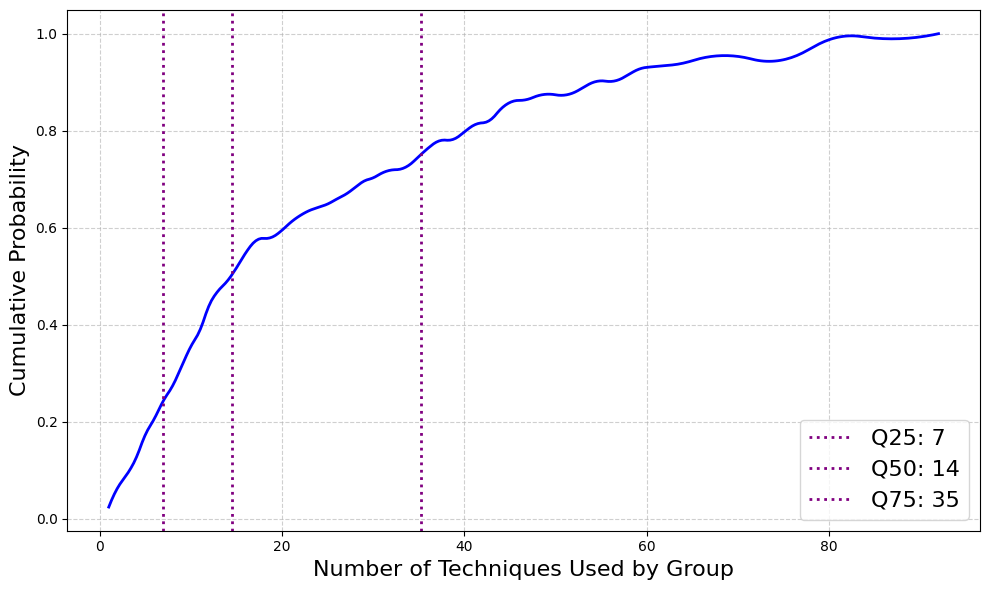

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(combined_stats["x_smooth"], combined_stats["cdf_smooth"], color='blue', linewidth=2)

# Add quartile lines
for q, val in combined_stats["quartiles"].items():
    plt.axvline(val, color='purple', linestyle='dotted', linewidth=2, label=f'Q{int(q*100)}: {val:.0f}')

plt.xlabel('Number of Techniques Used by Group', fontsize=16)
plt.ylabel('Cumulative Probability', fontsize=16)
#plt.title('CDF of Techniques Used Per Group (Combined Domains)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('figure/technique_distribution_cdf_combined.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [46]:
def compute_cdf_groups_per_technique(data):
    """
    Calculates how many distinct groups use each technique and generates CDF data.

    Parameters
    ----------
    data : DataFrame
        Combined mapping data from all domains.

    Returns
    -------
    dict
        Stats and smooth CDF arrays for plotting.
    """
    # Count how many unique groups (source names) use each technique
    group_counts_per_technique = data.groupby('target ID')['source name'].nunique()
    series = group_counts_per_technique.sort_values()

    # Compute raw CDF
    sorted_counts = np.sort(series)
    cdf = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)

    # Smooth CDF via interpolation
    x_to_y = defaultdict(list)
    for x, y in zip(sorted_counts, cdf):
        x_to_y[x].append(y)

    x_unique = np.array(sorted(x_to_y.keys()))
    y_avg = np.array([np.mean(x_to_y[x]) for x in x_unique])

    x_smooth = np.linspace(x_unique.min(), x_unique.max(), 300)
    spline = make_interp_spline(x_unique, y_avg, k=2)
    cdf_smooth = spline(x_smooth)

    return {
        "group_counts": series.tolist(),
        "mean": series.mean(),
        "median": series.median(),
        "std": series.std(),
        "min": series.min(),
        "max": series.max(),
        "quartiles": series.quantile([0.25, 0.5, 0.75]),
        "mode": series.mode()[0] if not series.mode().empty else None,
        "x_smooth": x_smooth,
        "cdf_smooth": cdf_smooth
    }


In [47]:
cdf_stats_technique = compute_cdf_groups_per_technique(combined_data)


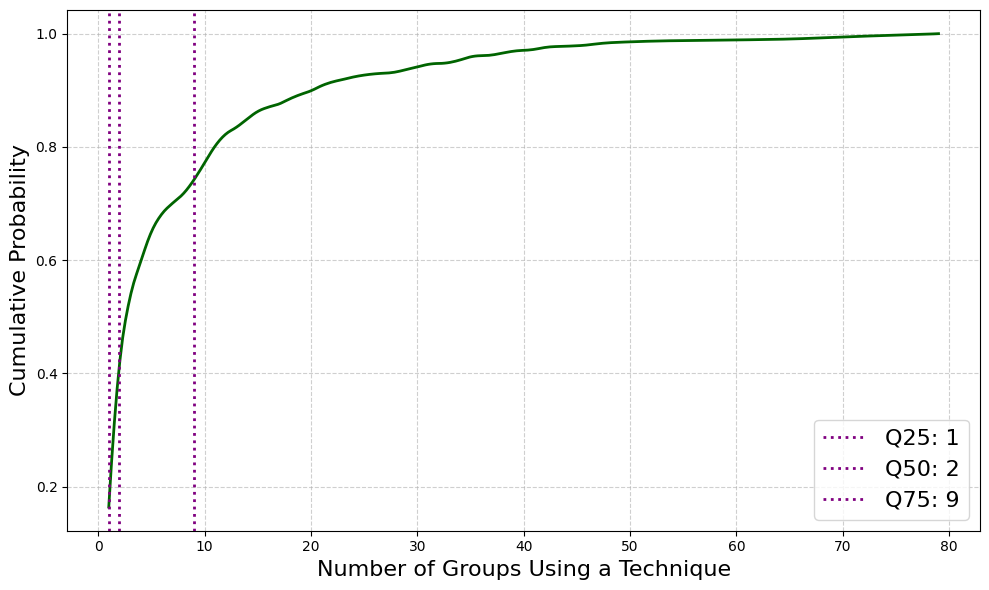

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(cdf_stats_technique["x_smooth"], cdf_stats_technique["cdf_smooth"],
         color='darkgreen', linewidth=2)

# Add quartile lines
for q, val in cdf_stats_technique["quartiles"].items():
    plt.axvline(val, color='purple', linestyle='dotted', linewidth=2, label=f'Q{int(q*100)}: {val:.0f}')

plt.xlabel('Number of Groups Using a Technique', fontsize=16)
plt.ylabel('Cumulative Probability', fontsize=16)
#plt.title('CDF of Groups per Technique (All Domains)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig('figure/groups_per_technique_cdf.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [30]:
print("=== Technique Usage Across Groups ===")
print(f"Mean: {cdf_stats_technique['mean']:.2f}")
print(f"Median: {cdf_stats_technique['median']:.2f}")
print(f"Std Dev: {cdf_stats_technique['std']:.2f}")
print(f"Min: {cdf_stats_technique['min']}")
print(f"Max: {cdf_stats_technique['max']}")
print(f"Mode: {cdf_stats_technique['mode']}")
print(f"Quartiles:\n{cdf_stats_technique['quartiles']}")


=== Technique Usage Across Groups ===
Mean: 7.61
Median: 2.00
Std Dev: 11.81
Min: 1
Max: 79
Mode: 1
Quartiles:
0.25    1.0
0.50    2.0
0.75    9.0
Name: source name, dtype: float64


In [62]:
def plot_cdf_unique_techniques_per_group(unique_techniques_per_group_only):
    """
    Plot a smooth CDF for number of unique techniques per group,
    with quartile markers and summary statistics.

    Parameters
    ----------
    unique_techniques_per_group_only : dict
        Dictionary mapping group name to list of uniquely used techniques.
    """
    # Count of unique techniques per group
    counts = [len(techs) for techs in unique_techniques_per_group_only.values()]
    if not counts:
        print("No data to plot.")
        return

    series = pd.Series(counts)
    mean_val = series.mean()
    median_val = series.median()
    std_val = series.std()
    min_val = series.min()
    max_val = series.max()
    quartiles = series.quantile([0.25, 0.5, 0.75])
    mode_val = series.mode()[0] if not series.mode().empty else None

    # Print stats
    print("Statistics for Unique Techniques per Group:")
    print(f"Mean: {mean_val:.2f}")
    print(f"Median: {median_val}")
    print(f"Standard Deviation: {std_val:.2f}")
    print(f"Min: {min_val}, Max: {max_val}")
    print("Quartiles:")
    print(quartiles)
    print(f"Mode: {mode_val}")

    # Sort and CDF
    counts = sorted(counts)
    cdf = np.arange(1, len(counts) + 1) / len(counts)

    # Smooth
    x_to_y = defaultdict(list)
    for x, y in zip(counts, cdf):
        x_to_y[x].append(y)
    x_unique = np.array(sorted(x_to_y.keys()))
    y_avg = np.array([np.mean(x_to_y[x]) for x in x_unique])

    if len(x_unique) > 3:
        x_smooth = np.linspace(x_unique.min(), x_unique.max(), 300)
        spline = make_interp_spline(x_unique, y_avg, k=2)
        y_smooth = spline(x_smooth)
    else:
        x_smooth = x_unique
        y_smooth = y_avg

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_smooth, y_smooth, color='darkorange', linewidth=2, label='')
    
    # Quartile markers
    for q, val in quartiles.items():
        plt.axvline(val, color='purple', linestyle='dotted', linewidth=2, label=f'Q{int(q*100)}: {val:.0f}')

    plt.xlabel('Number of Unique Techniques Used by Group', fontsize=15)
    plt.ylabel('Cumulative Probability', fontsize=15)
    #plt.title('CDF of Unique Techniques per Group', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=13)
    plt.tight_layout()
    plt.savefig('figure/unique_techniques_per_group_cdf_with_quartiles.pdf', format='pdf', bbox_inches='tight')
    plt.show()


Statistics for Unique Techniques per Group:
Mean: 0.99
Median: 0.0
Standard Deviation: 2.27
Min: 0, Max: 16
Quartiles:
0.25    0.0
0.50    0.0
0.75    1.0
dtype: float64
Mode: 0


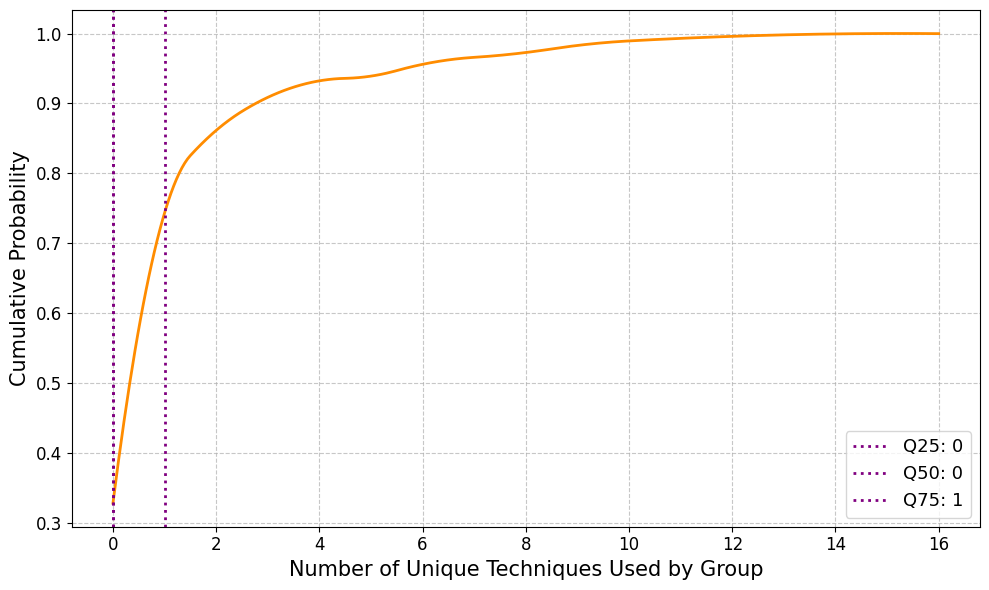

In [63]:
plot_cdf_unique_techniques_per_group(unique_only)